# XAI CODE DEMO

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/global_explanations.ipynb)

# Global Explanations 🌎

Table of Contents
* [Partial Dependence Plots](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=b9WMrsxrSc4Z&line=1&uniqifier=1)
* [ALE Plots](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=H4na5VBGOath&line=6&uniqifier=1)
* [Permutation Feature Importance](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=SLIGY1TLbSVm&line=21&uniqifier=1)
* [Feature Interaction](https://colab.research.google.com/drive/1WhBODDgVGE4NdnWtCouRuFn8rj0oxT6K#scrollTo=Fn1TE2O-aByw&line=6&uniqifier=1)

In [ ]:
!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)

**Dataset**
We will use the classic [UCI adult income dataset](https://archive.ics.uci.edu/dataset/2/adult). This is a classification task to predict if people made over $50k in the 1990's.

**Model**
We will train an XGBoost classifier model with default parameters for explanatory purposes. We are also performing a 50-50 train/test split for optimization purposes.

In [ ]:
# Load Data from shap library
X,y = shap.datasets.adult()

# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

## Partial Dependence Plots (PDP) 📈

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model [Paper, 2001](https://jerryfriedman.su.domains/ftp/trebst.pdf)

**How it Works:**
1. Select feature of interest
2. For every instance in training dataset:
* Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
* Make predictions with the black box model for newly created instances
* You now have a set of points for an instance with the feature value from the grid and the respective predictions
3. Average across all instances and plot

Here we will show both a built-in library implementation, [scikit learn's Partial Dependence Display](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html) and we will build our own implementation in numpy.


#### Using PartialDependenceDisplay

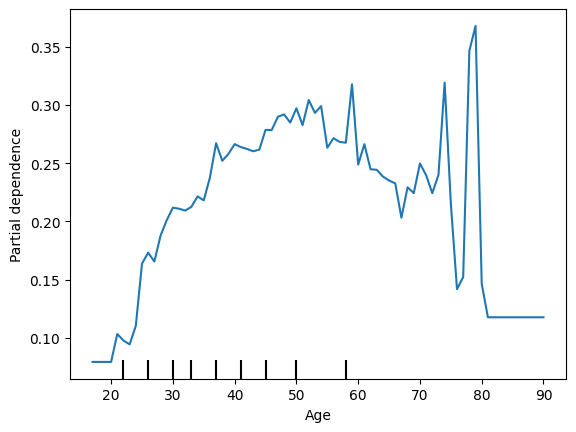

In [ ]:
# Choose the feature of interest
features = ["Age"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

#### Build our own PDP with numpy

When we build our own, you will notice we build our own grid of values and can change the size of our grid.

This is why you may see slight variations between the PDP created with numpy versus the PartialDependenceDisplay from scikit learn.

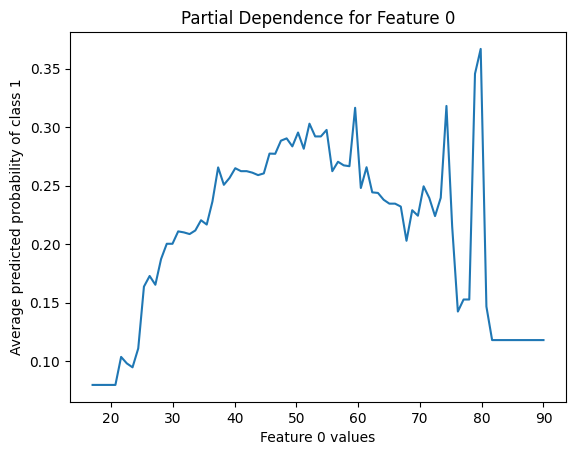

In [ ]:
# Choose the feature for which you want to plot partial dependence
feature_index = 0  # For example, the first feature

# Create feature grid - here is where you can update the size of the grid by updating num
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate the dataset to modify feature values
X_modified = X.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for all instances
    X_modified.iloc[:, feature_index] = value

    # Predict using the modified dataset
    predictions = model.predict_proba(X_modified)[:, 1]

    # Calculate average prediction for the current feature value
    average_predictions[i] = np.mean(predictions)

# Plot the partial dependence for the chosen feature
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature {feature_index} values')
plt.ylabel('Average predicted probability of class 1')
plt.title(f'Partial Dependence for Feature {feature_index}')
plt.show()

When we build our own PDP, we can run interesting experiments, like the one below, where we can see the impact of changing the size of our grid.

#### How to Interpret

* Look at the shape of the curve on the plot. Is it linear, non-linear, or does it have any particular pattern? This gives you insights into how the feature affects the prediction.

* Determine whether increasing or decreasing values of the feature variable lead to higher or lower predictions. Does the curve slope upwards, downwards, or remain relatively flat?

* Note whether the curve reaches a plateau or has any upper or lower limits. This indicates whether there's a point beyond which changing the feature variable has little effect on the prediction.

* Consider how the observed relationships align with your understanding of the problem domain. Are the results intuitive? Do they make sense based on what you know about the data?


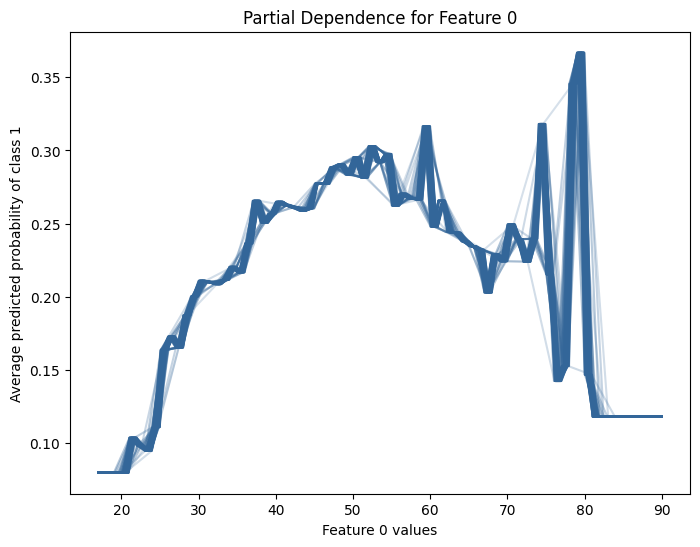

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

grid_length = np.linspace(20, 120, 40)
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axis for plotting

# Define a base color and alpha (transparency) values
base_color = (0.2, 0.4, 0.6)  # Blue-ish color
min_alpha = 0.2
max_alpha = 1.0

# Normalize grid_length values between 0 and 1
normalized_g = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())

for i, g in enumerate(grid_length):
    # Create feature grid
    feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=int(g))
    # Initialize array to store average predictions
    average_predictions = np.zeros_like(feature_values)
    # Duplicate the dataset to modify feature values
    X_modified = X.copy()
    # Loop over feature values
    for j, value in enumerate(feature_values):
        # Set the chosen feature to the current value for all instances
        X_modified.iloc[:, feature_index] = value
        # Predict using the modified dataset
        predictions = model.predict_proba(X_modified)[:, 1]
        # Calculate average prediction for the current feature value
        average_predictions[j] = np.mean(predictions)
    # Calculate color based on normalized g
    alpha = min_alpha + (max_alpha - min_alpha) * normalized_g[i]
    color = to_rgba(base_color, alpha)
    # Plot the partial dependence for the chosen feature
    ax.plot(feature_values, average_predictions, color=color)

ax.set_xlabel(f'Feature {feature_index} values')
ax.set_ylabel('Average predicted probability of class 1')
ax.set_title(f'Partial Dependence for Feature {feature_index}')
plt.show()

## ALE Plots 📉

Accumulated Local Effects (ALE) Plots [Paper, 2020](https://www.scholars.northwestern.edu/en/publications/visualizing-the-effects-of-predictor-variables-in-black-box-super)

**How to create an ALE plot:**
1. Bin the Feature: Divide the feature of interest into several intervals (bins). These bins help in managing the data and computing local effects within smaller, more manageable segments.
2. Compute Local Effects: For each bin, calculate the local effect of the feature on the prediction. This involves: Calculating the change in prediction when moving from the lower to the upper edge of the bin
Averaging this change over all instances that fall into that bin
3. Accumulate Effects: Starting from the first bin, accumulate the local effects across all bins. Sum up the average effects sequentially to show how the feature influences the prediction as its value changes
4. Centering: To make the plot more interpretable, center the accumulated effects around zero. Subtract the mean of the accumulated effects, which forces the interpretation to focus on deviations from the average prediction

There are a few python implementations of ALE plots, here we show the [ALEPython implementation](https://github.com/blent-ai/ALEPython).

The implementation is more complex and less intuitive than PDPs, with many hyperparameters, including:
* **bins** - This parameter defines the number of bins to divide the range of the specified feature into. A larger number of bins can provide more granularity in the ALE plot but might also increase computation time.
* **monte_carlo** - This parameter is a boolean flag indicating whether to use Monte Carlo sampling to estimate the ALE. Monte Carlo sampling can be beneficial when the number of samples in the dataset is large, as it reduces computational burden.
* **monte_carlo_rep** - This parameter specifies the number of Monte Carlo replicates to use for estimating the ALE. More replicates can lead to a more accurate estimation but may also increase computation time.
* **monte_carlo_ratio** - This parameter determines the proportion of the dataset to use for Monte Carlo sampling. It's a value between 0 and 1, where 1 means using the entire dataset. Using a smaller ratio can speed up computation but may introduce some sampling error.


This can take a couple of minutes to run:

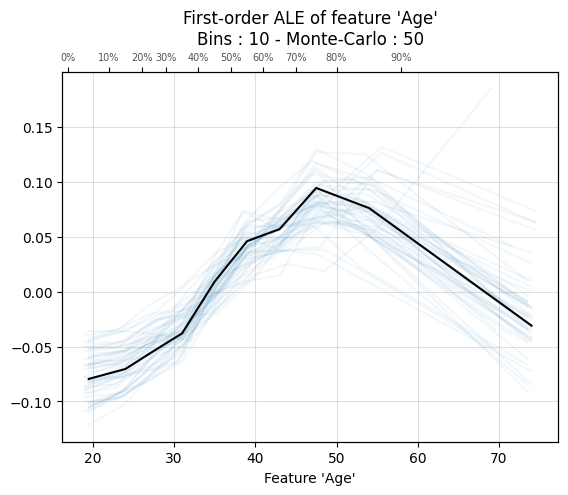

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Age'">

In [ ]:
# Use default parameters for 1D Main Effect ALE Plot
ale_plot(model, X_train, 'Age', monte_carlo=True)

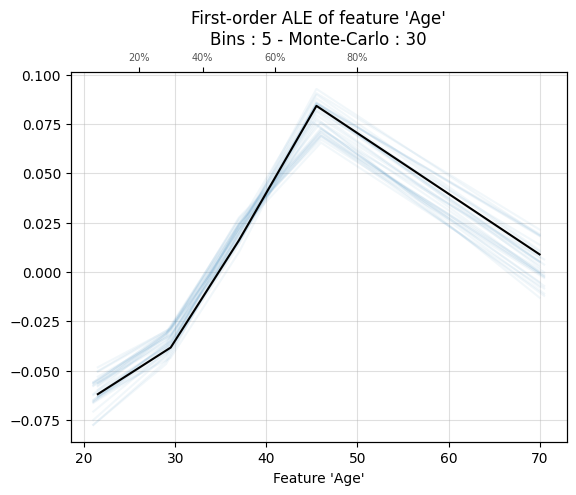

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Age'">

In [ ]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "Age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

#### How to Interpret 1D Main Effect ALE Plot



* X-axis represents feature values
* Y-axis shows average effect on predictions
* Each curve represents a feature's ALE. - Flat curves imply little impact; steep curves, significant impact
* Upward curves: increasing feature value increases predictions; downward, the opposite
* Steeper curves signify larger effects

We can compare ALE plots to gauge relative feature importance.
Features with steeper curves have larger impacts.

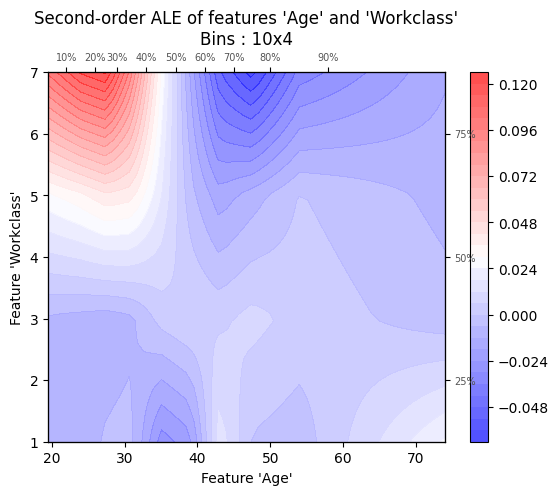

<Axes: title={'center': "Second-order ALE of features 'Age' and 'Workclass'\nBins : 10x4"}, xlabel="Feature 'Age'", ylabel="Feature 'Workclass'">

In [ ]:
# 2D Second-Order ALE Plot
ale_plot(model, X_train, X_train.columns[:2], bins=10)

#### How to Interpret - 2D Second-Order ALE Plot

* Both axes represent the values of the two features being analyzed.
* Each axis corresponds to one of the features.
* The plot displays a surface where the height represents the average effect on predictions. Higher points indicate regions where the model tends to make higher predictions, and vice versa.
* Patterns in the surface reveal how the joint behavior of the two features affects the model's predictions. Peaks or valleys suggest regions where the joint effect is particularly strong.
* The direction of the slope indicates whether increasing one feature while holding the other constant tends to increase or decrease predictions. Steeper slopes represent larger effects, while flatter regions indicate smaller effects.


We can compare the 2D Second-Order ALE Plot with individual ALE plots for each feature to understand how joint effects differ from marginal effects.

## Permutation Feature Importance

The importance of a feature can be measured by calculating how much model’s prediction error increases after permuting the feature.
* If shuffling a feature’s values increases the model error, the feature is important
* If the model error doesn’t change after shuffling a feature’s values, a feature is considered unimportant

First introduced for random forests [Paper, 2001](https://link.springer.com/article/10.1023/A:1010933404324). Updated to be model agnostic - renamed “model reliance” [Paper, 2018](https://arxiv.org/abs/1801.01489).

**Process for Model Agnostic measure:**
1. Input: Trained model 𝑓^, feature matrix 𝑋, target vector 𝑦, error measure 𝐿(𝑦,𝑓^).
2. Estimate the original model error 𝑒𝑜𝑟𝑖𝑔=𝐿(𝑦,𝑓^(𝑋)) (e.g. mean squared error)
3. For each feature 𝑗∈{1,...,𝑝}:
* Generate feature matrix 𝑋𝑝𝑒𝑟𝑚 by permuting feature j in the data X. This breaks the association between feature j and true outcome y
* Estimate error 𝑒𝑝𝑒𝑟𝑚=𝐿(𝑌,𝑓^(𝑋𝑝𝑒𝑟𝑚)) based on the predictions of the permuted data.
* Calculate permutation feature importance as quotient 𝐹𝐼𝑗=𝑒𝑝𝑒𝑟𝑚/𝑒𝑜𝑟𝑖𝑔 or difference 𝐹𝐼𝑗=𝑒𝑝𝑒𝑟𝑚 - 𝑒𝑜𝑟𝑖𝑔
4. Sort features by descending FI

**Implementation in Python**
Here we will demonstrate the implementation in the scikit-learn library.[[Documentation Here](https://scikit-learn.org/stable/modules/permutation_importance.html)]

The scikit-learn implementation of the permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances.

* n_repeats - number of times to permute a feature



In [29]:
# Compute permutation importances
perm_imp = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [30]:
# Print the mean and standard deviation of permutation importances for each feature

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")

Capital Gain0.049 +/- 0.001
Relationship0.034 +/- 0.002
Education-Num0.030 +/- 0.002
Age     0.019 +/- 0.001
Occupation0.019 +/- 0.002
Capital Loss0.012 +/- 0.001
Hours per week0.010 +/- 0.001
Marital Status0.006 +/- 0.001
Workclass0.006 +/- 0.001


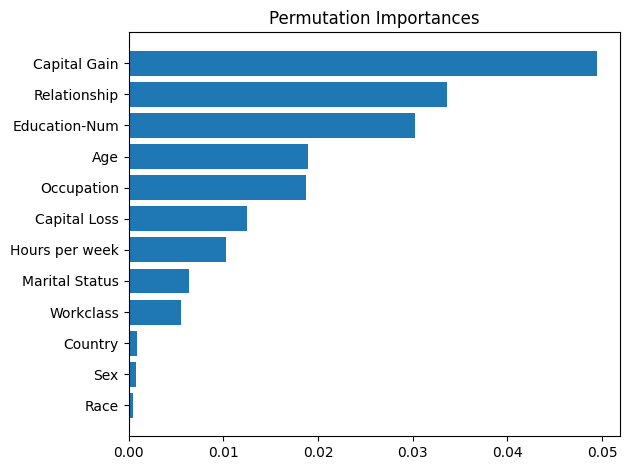

In [33]:
# Plot Permutation Feature Importances as a bar chart

sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

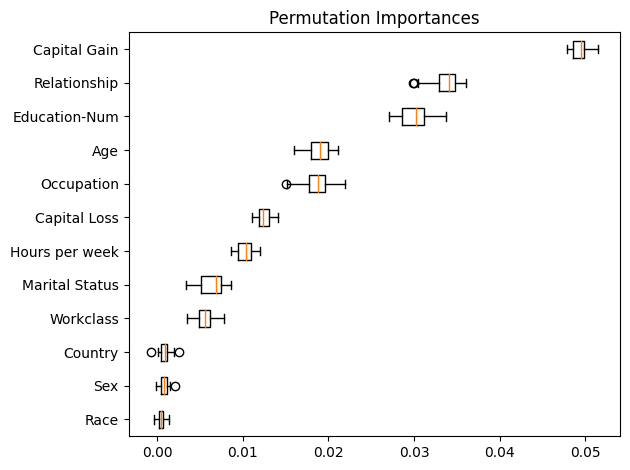

In [34]:
# Plot Permutation Feature Importances as a box plot

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

⚠️ Caution when using Permutation Feature Importance ⚠️

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. [Source](https://scikit-learn.org/stable/modules/permutation_importance.html#id2)

## Feature Interaction

Friedman's H-statistic is still being implemented in scikit-learn ([see PR here](https://github.com/scikit-learn/scikit-learn/pull/28375)). It is currently in progress ([code here](https://github.com/mayer79/scikit-learn/blob/friedmans-h/sklearn/inspection/_h_statistic.py))

When this is added to scikit-learn, I will update this tutorial.
